In [55]:
import torch 
from Ford_dataset import SatGrdDatasetFord, train_logs, train_logs_img_inds, test_logs, test_logs_img_inds
from torch.utils.data import DataLoader
from torchvision import transforms

class Config():
    device = 'cpu'
    cameras = ['FL', 'RL']
    # cameras = ['FL', 'SL', 'SR', 'RL']

    orig_satmap_A = 512
    sat_map_A = 64
    meter_per_pixel = 0.22 # this is fixed for the ford dataset meter per pixel of the original shape satellite map 512 * 512 

    vol_car_xyz = torch.tensor([128 , 128 , 6], dtype=torch.int64) * 4 #volume around car xyz shape, in training   
    orig_img_H = 448 #original image height that is going as input into the neural network 
    orig_img_W = 896

    #the output shape of the image encoder, later to be lifted to 3D 
    img_H = 448
    img_W = 896

config = Config()


logs_start = 0; logs_end = 1
range_lat = 20; range_lot=20; rotation_range =20; #meters, meters, degress
train_set  = SatGrdDatasetFord(logs=train_logs[logs_start:logs_end], logs_img_inds=train_logs_img_inds[logs_start:logs_end], cameras=config.cameras, mode='train')
val_set = SatGrdDatasetFord(logs=test_logs[logs_start:logs_end], logs_img_inds=test_logs_img_inds[logs_start:logs_end], cameras=config.cameras, mode='val')


Rs = {key:item.to(config.device) for key, item in train_set.Rs.items()}
Ts = {key:item.to(config.device) for key, item in train_set.Ts.items()}
Ks = {key:item.to(config.device) for key, item in train_set.Ks.items()}

In [57]:

class Functions():
    def __init__(self, config) -> None:
        self.config = config

    def get_xyz_car(self):
        '''
        space around the ego vehicle:
        in voxels shape (x,y,z), default (128,128,4)
        space around the ego vehicle:
        in meters 
        x axis is looking front [-56.3, 56.3] 
        y axis is looking left  [-56.3, 56.3]
        z axis is looking down  [-4.6, 1.4]

        the axis of the vehicle is ?

        returns:
        xyz of shape(x,y,z, 3) where 3 represents the xyz position  
        xyz_id of shape(x,y,z, 3) where 3 is the index x,y,z of that cell 
        '''

        x = (torch.arange(self.config.vol_car_xyz[0], dtype=torch.float32) / (self.config.vol_car_xyz[0] -1)) - 0.5
        x = - x * self.config.orig_satmap_A * self.config.meter_per_pixel
        x = x.unsqueeze(1)
        x = x.repeat(1, self.config.vol_car_xyz[0])

        y = (torch.arange(self.config.vol_car_xyz[1], dtype=torch.float32) / (self.config.vol_car_xyz[1] -1)) - 0.5
        y = y * self.config.orig_satmap_A * self.config.meter_per_pixel
        y = y.unsqueeze(0)
        y = y.repeat(self.config.vol_car_xyz[1], 1)

        xyz = torch.stack((x,y, torch.zeros_like(y)), dim=2).unsqueeze(2)
        xyz = xyz.repeat(1, 1, self.config.vol_car_xyz[2], 1)

        offset = 1.4 #for -0.3 we are at the level of the front camera, for 1.4 we are at the ground level 
        z = offset + ((torch.arange(self.config.vol_car_xyz[2], dtype=torch.float32) / (self.config.vol_car_xyz[2] -1)) -1) * 6

        xyz[:,:,:,2] = z[:] 

        # xyz indices
        x_id = torch.arange(self.config.vol_car_xyz[0], dtype=torch.int64).unsqueeze(1)
        x_id = x_id.repeat(1, self.config.vol_car_xyz[0]) 

        y_id = torch.arange(self.config.vol_car_xyz[1], dtype=torch.int64).unsqueeze(0)
        y_id = y_id.repeat(self.config.vol_car_xyz[1], 1)

        xy_id = torch.stack((x_id, y_id, torch.zeros_like(y_id)), dim =2).unsqueeze(2)
        
        xyz_id = xy_id.repeat(1,1,self.config.vol_car_xyz[2],1)
        xyz_id[:,:,:, 2] = torch.arange(self.config.vol_car_xyz[2], dtype=torch.int64)


        return xyz.contiguous(), xyz_id.contiguous()

    
    def render_xyz(self, R, T, K, xyz, xyz_ids):
        '''
        uvs shape [2, n] to calculate gather_ids used for image of shape [C,H,W]
        scatter_ids shape [3, n] used for volume of shape [C,H,W,Z]  
        '''
        K = K.clone()
        K[0] = K[0] * (self.config.img_W / self.config.orig_img_W)
        K[1] = K[1] * (self.config.img_H / self.config.orig_img_H)

        # R, T is from camera to body 
        # xyz relative to the car body, xyz_cam is relative to camera
        xyz_cam = (R.T @ xyz.view(-1,3).T - T.unsqueeze(1))
        print(xyz_cam[1, :].min(), xyz_cam[1, :].max())
        uvs = K @ xyz_cam
        uvs[0] = uvs[0]/ uvs[2]
        uvs[1] = uvs[1]/ uvs[2]

        bf = (uvs[0, :] >= 0) & (uvs[1, :] >= 0) & (uvs[0, :] < self.config.img_W-1) & (uvs[1, :]<self.config.img_H-1) & (uvs[2, :] > 0.1)

        # uvs = torch.round(uvs[:, bf]).type(torch.int64)
        uvs = uvs[:, bf]

        xyz_ids_filtered = xyz_ids.view(-1, 3).T[:, bf]
        scatter_ids = xyz_ids_filtered

        #v = x height u = y width in a matrix (v,u), uvs[0] -> u,y, uvs[1] -> v,x, ids = y + x * y_size
        # gather_ids = uvs[0] + self.config.img_W * uvs[1]
        # # ids = z + y * z_size + x * y_size * z_size
        # scatter_ids = xyz_ids_filtered[2] + xyz_ids_filtered[1] * self.config.vol_car_xyz[2] + xyz_ids_filtered[0] * self.config.vol_car_xyz[1] * self.config.vol_car_xyz[2]

        return uvs[:2], scatter_ids
    
    def lift_features(self, img, volume, uvs, scatter_ids):
        '''
        Lifting features using bilinear interpolation 
        
        img shape (3, H, W)
        volume shape (3, X, Y, Z)
        uvs shape (2,n)
        scatter_ids shape (3,n)
        '''
        gather_ids = torch.zeros_like(uvs)
        gather_ids[0, :] = uvs[1, :]
        gather_ids[1, :] = uvs[0, :]

        gather_ids_dl = gather_ids.clone() #down left 
        gather_ids_dl[0, :] = gather_ids_dl[0, :].floor()
        gather_ids_dl[1, :] = gather_ids_dl[1, :].floor()

        gather_ids_ul = gather_ids.clone() #up left 
        gather_ids_ul[0, :] = gather_ids_ul[0, :].floor() + 1.0
        gather_ids_ul[1, :] = gather_ids_ul[1, :].floor()

        gather_ids_ur = gather_ids.clone() #up right
        gather_ids_ur[0, :] = gather_ids_ur[0, :].floor() + 1.0
        gather_ids_ur[1, :] = gather_ids_ur[1, :].floor() + 1.0

        gather_ids_dr = gather_ids.clone() #down right 
        gather_ids_dr[0, :] = gather_ids_dr[0, :].floor()
        gather_ids_dr[1, :] = gather_ids_dr[1, :].floor() + 1.0

        x_u = gather_ids_ul[0, :] #up 
        x_d = gather_ids_dl[0, :] #down
        y_r = gather_ids_dr[1, :] #right
        y_l = gather_ids_dl[1, :] #left 

        w_dl = (x_u - gather_ids[0]) * (y_r - gather_ids[1]) #/ (x_u - x_d) * (y_r - y_l) #down left weights, no need to divide since the volume is always 1  
        w_ul = (gather_ids[0] - x_d) * (y_r - gather_ids[1]) #/ (x_u - x_d) * (y_r - y_l) #up left weights 
        w_ur = (gather_ids[0] - x_d) * (gather_ids[1] - y_l) #/ (x_u - x_d) * (y_r - y_l) #up right weights 
        w_dr = (x_u - gather_ids[0]) * (gather_ids[1] - y_l) #/ (x_u - x_d) * (y_r - y_l) #down right weights 

        gather_ids_dl = gather_ids_dl.to(torch.int64)
        gather_ids_ul = gather_ids_ul.to(torch.int64)
        gather_ids_ur = gather_ids_ur.to(torch.int64)
        gather_ids_dr = gather_ids_dr.to(torch.int64)

        volume[:, scatter_ids[0], scatter_ids[1], scatter_ids[2]] =  w_dl * img[:, gather_ids_dl[0], gather_ids_dl[1]] \
                                                                    + w_ul * img[:, gather_ids_ul[0], gather_ids_ul[1]] \
                                                                    + w_ur * img[:, gather_ids_ur[0], gather_ids_ur[1]] \
                                                                    + w_dr * img[:, gather_ids_dr[0], gather_ids_dr[1]] \
                                                                    
        return volume
        
    

tensor(0.2506) tensor(3.1602)


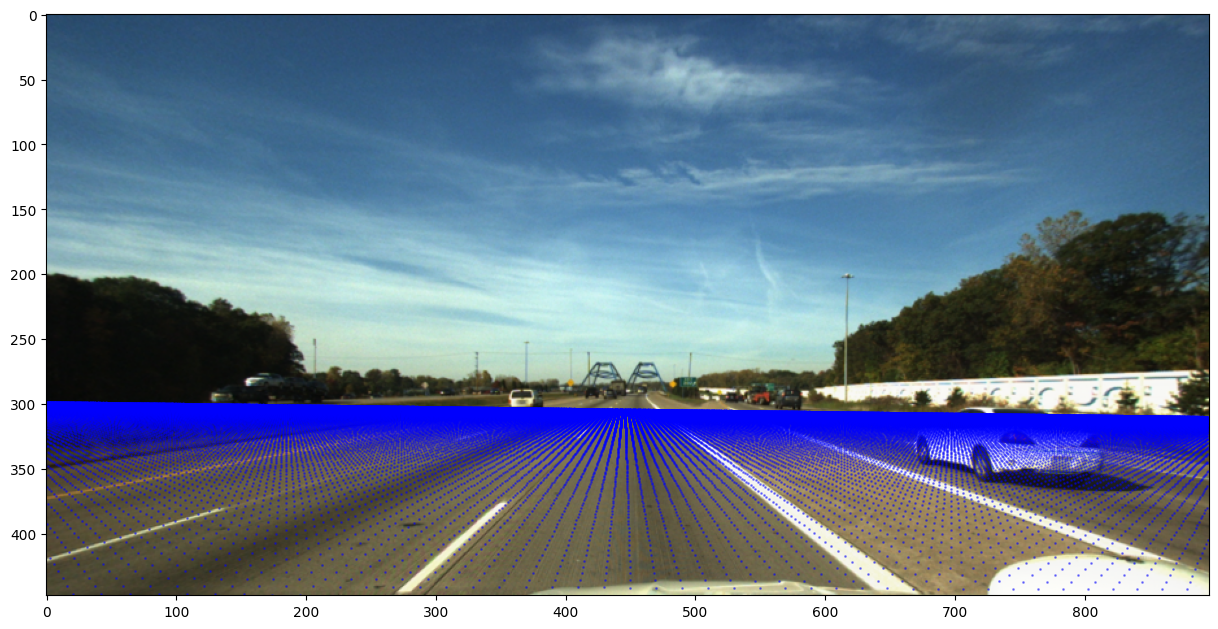

tensor(-1.4646) tensor(4.8598)


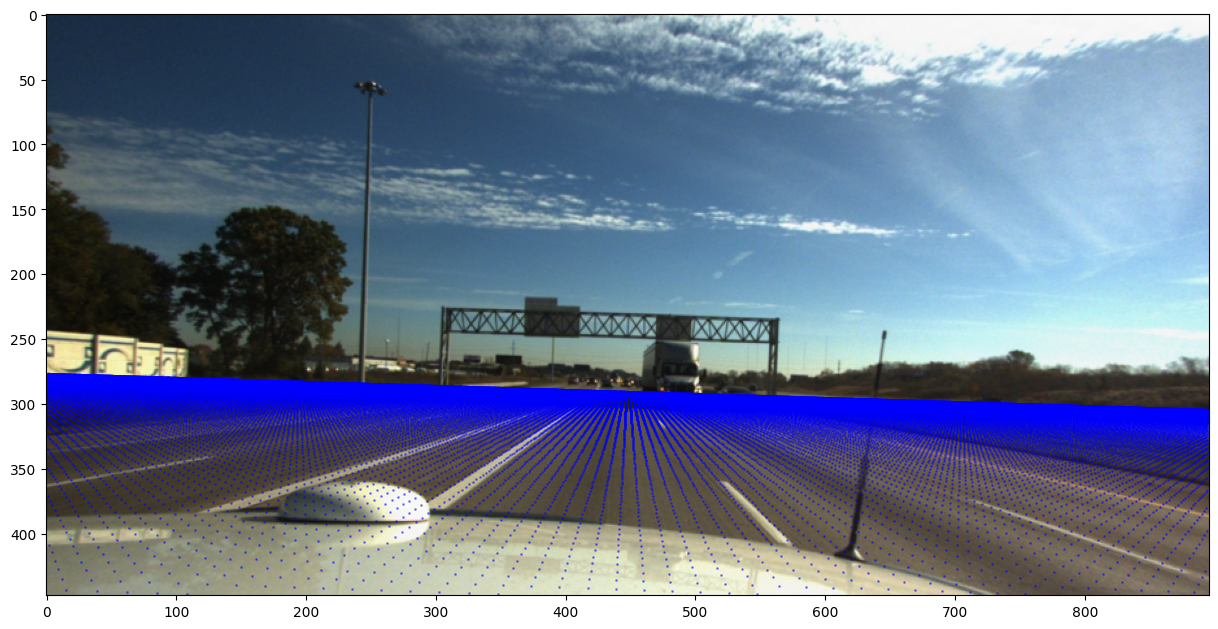

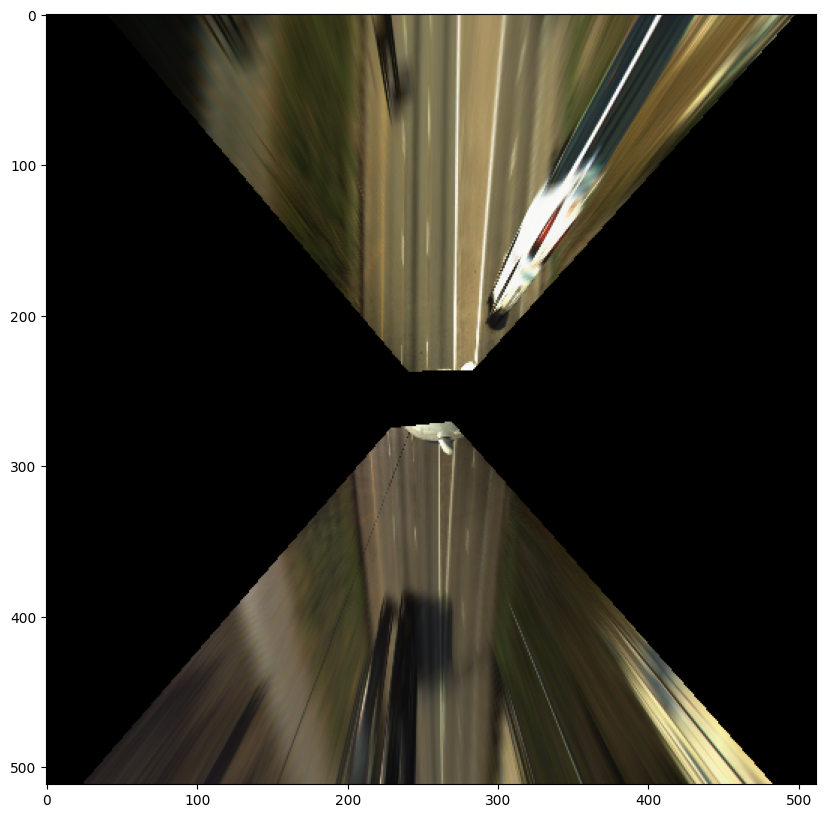

torch.Size([3, 512, 512, 24])

In [60]:
from matplotlib import pyplot as plt 
from torch.nn.functional import avg_pool2d
idx = 1000
sat_img, grd_imgs, gt_shift_u, gt_shift_v, theta, grd_names, sat_img_norot_notran, mask_dt_xy, dt_xy = train_set[idx]

functions = Functions(config)
xyz, xyz_ids = functions.get_xyz_car()
volume = torch.zeros((3, *config.vol_car_xyz), dtype=torch.float32)
xyz = xyz[:, :, -1:, :]
xyz_ids = xyz_ids[:,:, -1:, :]

for cam_id, camera in enumerate(config.cameras):
    img = transforms.Resize(size=(config.img_H, config.img_W))(grd_imgs[cam_id])

    uvs, scatter_ids = functions.render_xyz(Rs[camera], Ts[camera], Ks[camera], xyz, xyz_ids)
    volume = functions.lift_features(img, volume, uvs, scatter_ids)


    plt.figure(figsize=(15,15))
    plt.imshow(img.permute([1,2,0]))
    plt.scatter(uvs[0, :], uvs[1, :], s=1, color=(0,0,1), alpha=0.4) #plt considers x axis right and y axis down 
    plt.show()


plt.figure(figsize=(10,10))
plt.imshow(volume.permute(1,2,3,0)[:,:, -1, :])
plt.show()
volume.shape




tensor(13.8066) tensor(0.)


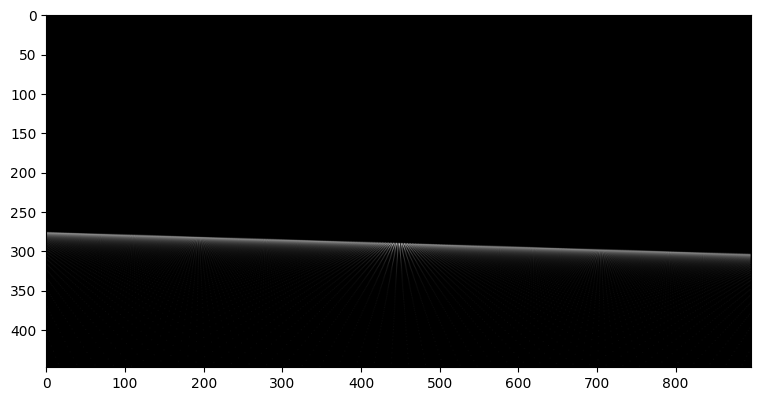

In [59]:
img1 = torch.nn.Parameter(img.clone(), requires_grad=True)
img2 = torch.nn.Parameter(img.clone(), requires_grad=True)

volume = torch.zeros((3, *config.vol_car_xyz), dtype=torch.float32)
functions.lift_features(img1, volume, uvs, scatter_ids)
# volume.view(3, -1)[:, scatter_ids[:10000]] = img2.view(3, -1)[:, gather_ids[:10000]] 
loss = volume.sum()
loss.backward()


plt.figure(figsize=(20,20))
img_grad1 = img1.grad.permute([1,2,0])
print(img_grad1.max(), img_grad1.min())
img_grad1 = img_grad1/img_grad1.max()
plt.subplot(1,2,1)
plt.imshow(img_grad1)


# img_grad2 = img2.grad.permute([1,2,0])
# print(img_grad2.max(), img_grad2.min())
# img_grad2 = img_grad2/img_grad2.max() * 5
# plt.subplot(1,2,2)
# plt.imshow(img_grad2)
# plt.show()
